<h1>Study of the savgol_filter for simulated single photon signals</h1>

Interesting sourcers:
- https://nirpyresearch.com/choosing-optimal-parameters-savitzky-golay-smoothing-filter/
- https://arxiv.org/pdf/1808.10489.pdf

The purpose of this notebook is to evaluate, compared to our case, how much the <code>window_length</code> and the <code>polynomial order</code> weigh in obtaining an optimal condition on which to work for the second derivative. In such a way as to always be able to find the correct local critical point (which coincides with the starting point of the signal) and evaluate its intersection with a parabola for a more correct estimate.

In [124]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

def gen_signal(x=np.linspace(0,1000,1000), baseline=0, amplitude=140, rise_time=40, decay_time=60, pulse_start=200, noise_lev=0.5, plot=False):
    signal = baseline+1*amplitude*(np.exp(-x/rise_time)-np.exp((-x/decay_time)))
    signal = np.interp(x, x+pulse_start, signal)
    noise = np.random.normal(scale=noise_lev, size=len(signal))

    if plot:
        plt.plot(x, signal+noise)
        plt.plot(x, signal, c='r')
        plt.show()

    return signal+noise, signal

Introduction of a parameter that allows quantifying the gap between the simulated signal and the fit generated by the <code>savgol_filter</code>.
Note that the <code>savgol_filter</code> mode has been introduced to deal with points at the extremes.


In this case we are using <code>mirror</code>. See the <a href='https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html'>notes</a> for more details.

In [125]:
def savgol_rss(sample, clean, window_length, poly, n=0, plot=False, plot_color='b'):
    rss = []
    derivative_func = savgol_filter(sample, window_length, poly, n, delta=1, mode='mirror' )

    for k in range(len(sample)):
        rss.append((clean[k] - derivative_func[k])**2)
    
    if plot:
        plt.scatter(np.linspace(0,len(sample), len(sample)), derivative_func, s=1, c=plot_color)
        
    return sum(rss)

We fix a (intermediate) <code>noise_lev</code> and a random <code>window_length</code> and evaluate the discrepancy of signals at different <code>amplitudes</code>.
- The lower the degree of the polynomial the more suppressed is the noise;
- The higher the degree of the polynomial the less suppressed is the noise.

In [126]:
signal, clean, total_rss = [], [], []
amplitudes = np.linspace(10, 300, 5)
wl = 15
pol = wl-1

for amp in amplitudes:
    tmp1, tmp2 = gen_signal(baseline=-10, amplitude=amp, noise_lev=1, plot=False, pulse_start=np.random.uniform(199.5,200.5))
    signal.append(tmp1)
    clean.append(tmp2)

for i in range(len(signal)):
    rss = []
    for p in range(pol):
        rss.append(savgol_rss(signal[i], clean[i], window_length=wl, poly=p, n=0, plot=False))

    total_rss.append(rss)

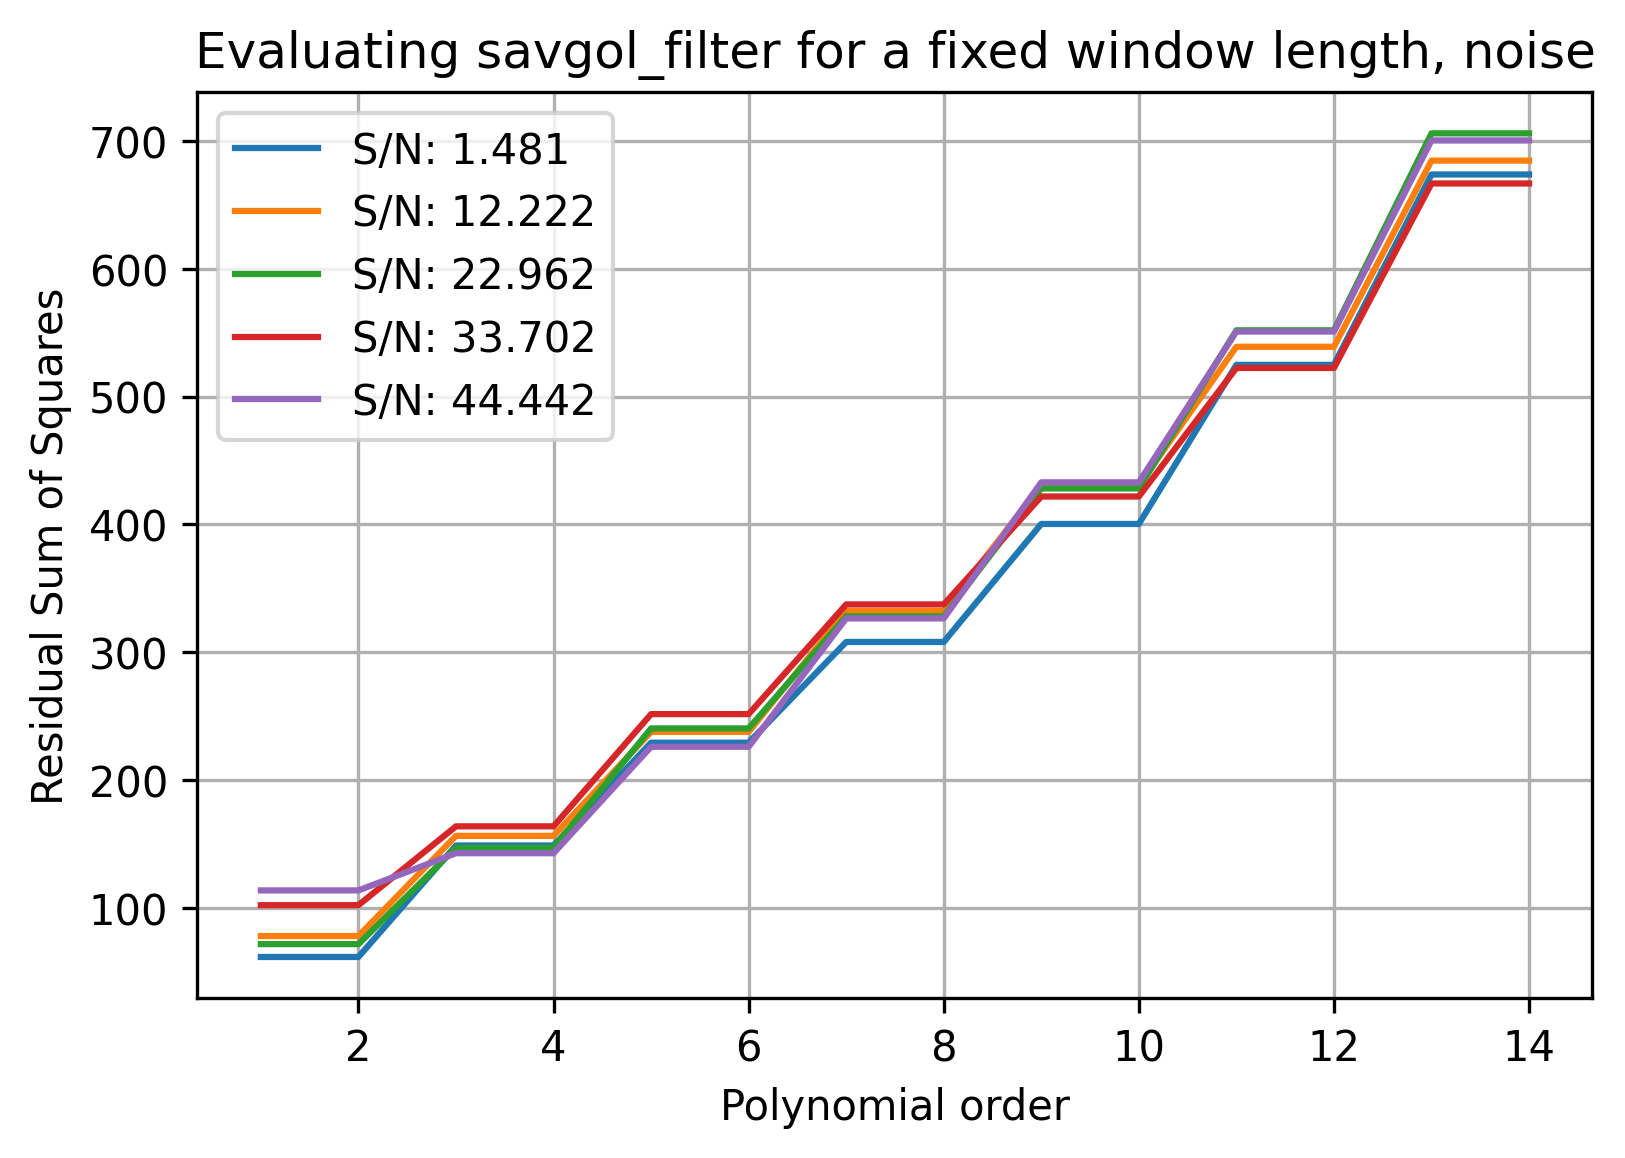

In [127]:
plt.figure(dpi = 300)
for k in range(len(total_rss)):
    plt.plot(np.linspace(1, pol, pol), total_rss[k], label='S/N: ' + str(round(0.148140 * amplitudes[k] + 0.000032, 3)))

plt.title('Evaluating savgol_filter for a fixed window length, noise')
plt.xlabel('Polynomial order')
plt.ylabel('Residual Sum of Squares')
plt.legend()
plt.grid()
plt.show()

We fix a (intermediate) <code>amplitude</code> and a random <code>window_length</code> and evaluate the discrepancy of signals at different <code>noises</code>.
- The lower the degree of the polynomial the more suppressed is the noise;
- The higher the degree of the polynomial the less suppressed is the noise.

In [128]:
signal, clean, total_rss = [], [], []
noises = np.linspace(0.5, 2.5, 5)
wl = 30
pol = 10

for noise in noises:
    tmp1, tmp2 = gen_signal(baseline=-10, amplitude=30, noise_lev=noise, plot=False, pulse_start=np.random.uniform(199.5,200.5))
    signal.append(tmp1)
    clean.append(tmp2)
for i in range(len(signal)):
    rss = []
    for p in range(pol):
        rss.append(savgol_rss(signal[i], clean[i], window_length=wl, poly=p, n=0, plot=False))

    total_rss.append(rss)

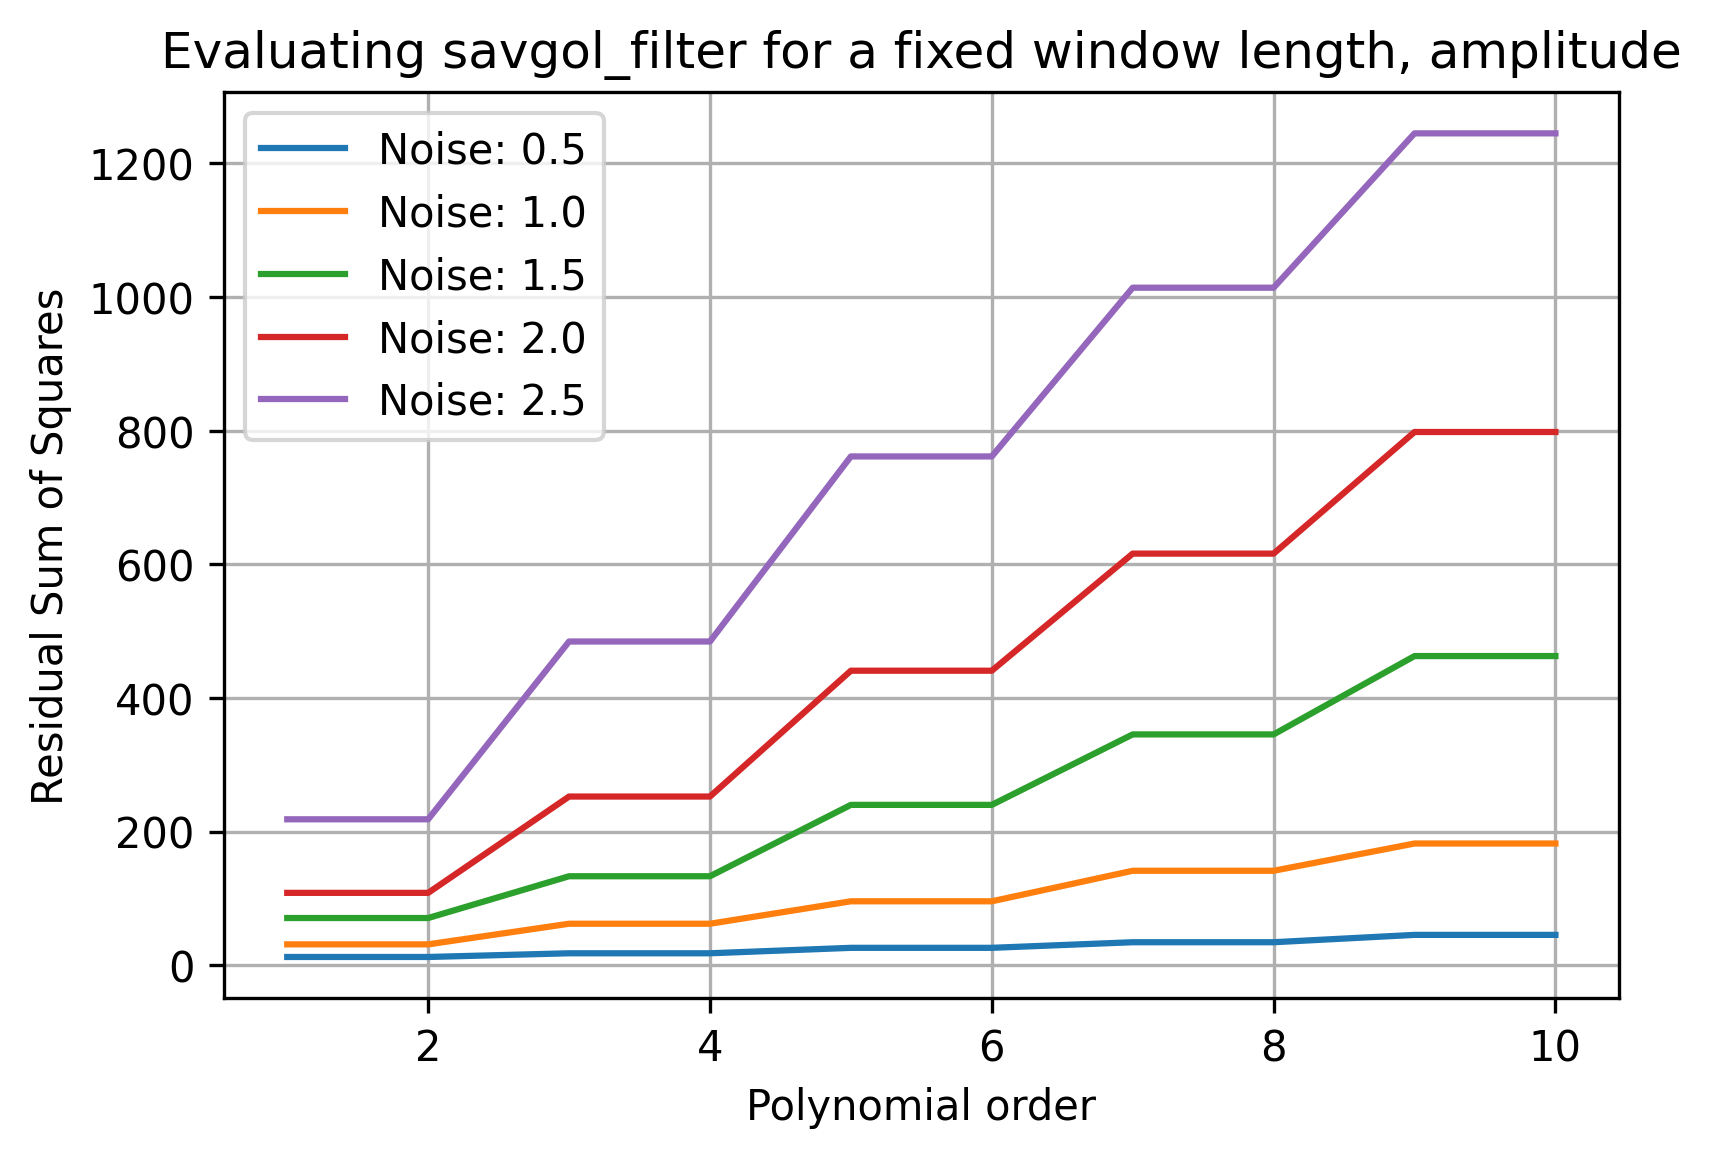

In [129]:
plt.figure(dpi = 300)
for k in range(len(total_rss)):
    plt.plot(np.linspace(1, pol, pol), total_rss[k], label='Noise: ' + str(noises[k]))

plt.title('Evaluating savgol_filter for a fixed window length, amplitude')
plt.xlabel('Polynomial order')
plt.ylabel('Residual Sum of Squares')
plt.legend()
plt.grid()
plt.show()

We fix a (intermediate) <code>noise_lev</code> and a low <code>polynomial order</code> and evaluate the discrepancy of signals at different <code>amplitudes</code>.
- The greater the window_length the more suppressed is the noise;
- The smaller the window_length the less suppressed is the noise.

In [130]:
signal, clean, total_rss = [], [], []
amplitudes = np.linspace(10, 300, 5)
pol = 6
wl = [20, 25, 30, 35, 40, 45, 50, 55, 60]

for amp in amplitudes:
    tmp1, tmp2 = gen_signal(baseline=-10, amplitude=amp, noise_lev=1, plot=False, pulse_start=np.random.uniform(199.5,200.5))
    signal.append(tmp1)
    clean.append(tmp2)
for i in range(len(signal)):
    rss = []
    for swl in wl:
        rss.append(savgol_rss(signal[i], clean[i], window_length=swl, poly=pol, n=0, plot=False))

    total_rss.append(rss)

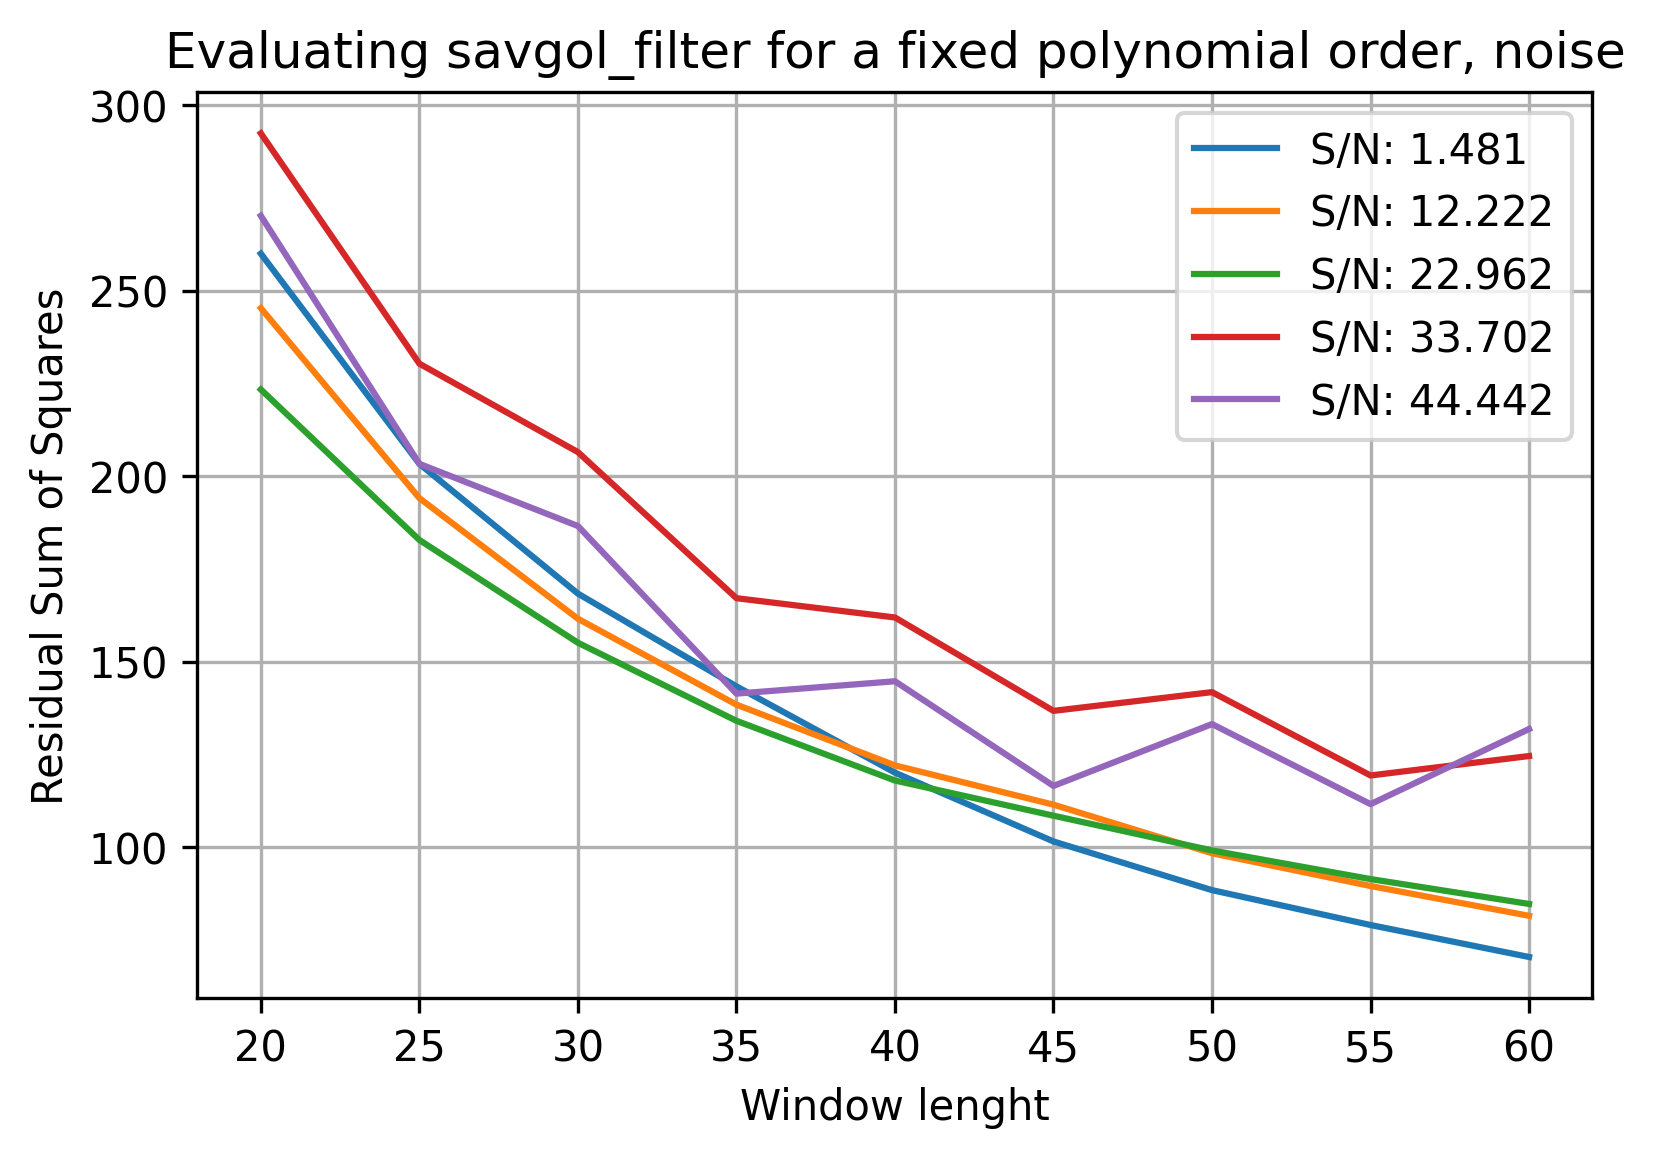

In [131]:
plt.figure(dpi = 300)
for k in range(len(total_rss)):
    plt.plot(wl, total_rss[k], label='S/N: ' + str(round(0.148140 * amplitudes[k] + 0.000032, 3)))

plt.title('Evaluating savgol_filter for a fixed polynomial order, noise')
plt.xlabel('Window lenght')
plt.ylabel('Residual Sum of Squares')
plt.legend()
plt.grid()
plt.show()

We fix a (intermediate) <code>amplitude</code> and a low <code>polynomial order</code> and evaluate the discrepancy of signals at different <code>noises</code>.
- The greater the window_length the more suppressed is the noise;
- The smaller the window_length the less suppressed is the noise.

In [132]:
signal, clean, total_rss = [], [], []
noises = np.linspace(0.5, 2.5, 5)
pol = 4
wl = [20, 25, 30, 35, 40, 45, 50, 55, 60]

for noise in noises:
    tmp1, tmp2 = gen_signal(baseline=-10, amplitude=30, noise_lev=noise, plot=False, pulse_start=np.random.uniform(199.5,200.5))
    signal.append(tmp1)
    clean.append(tmp2)
for i in range(len(signal)):
    rss = []
    for swl in wl:
        rss.append(savgol_rss(signal[i], clean[i], window_length=swl, poly=pol, n=0, plot=False))

    total_rss.append(rss)

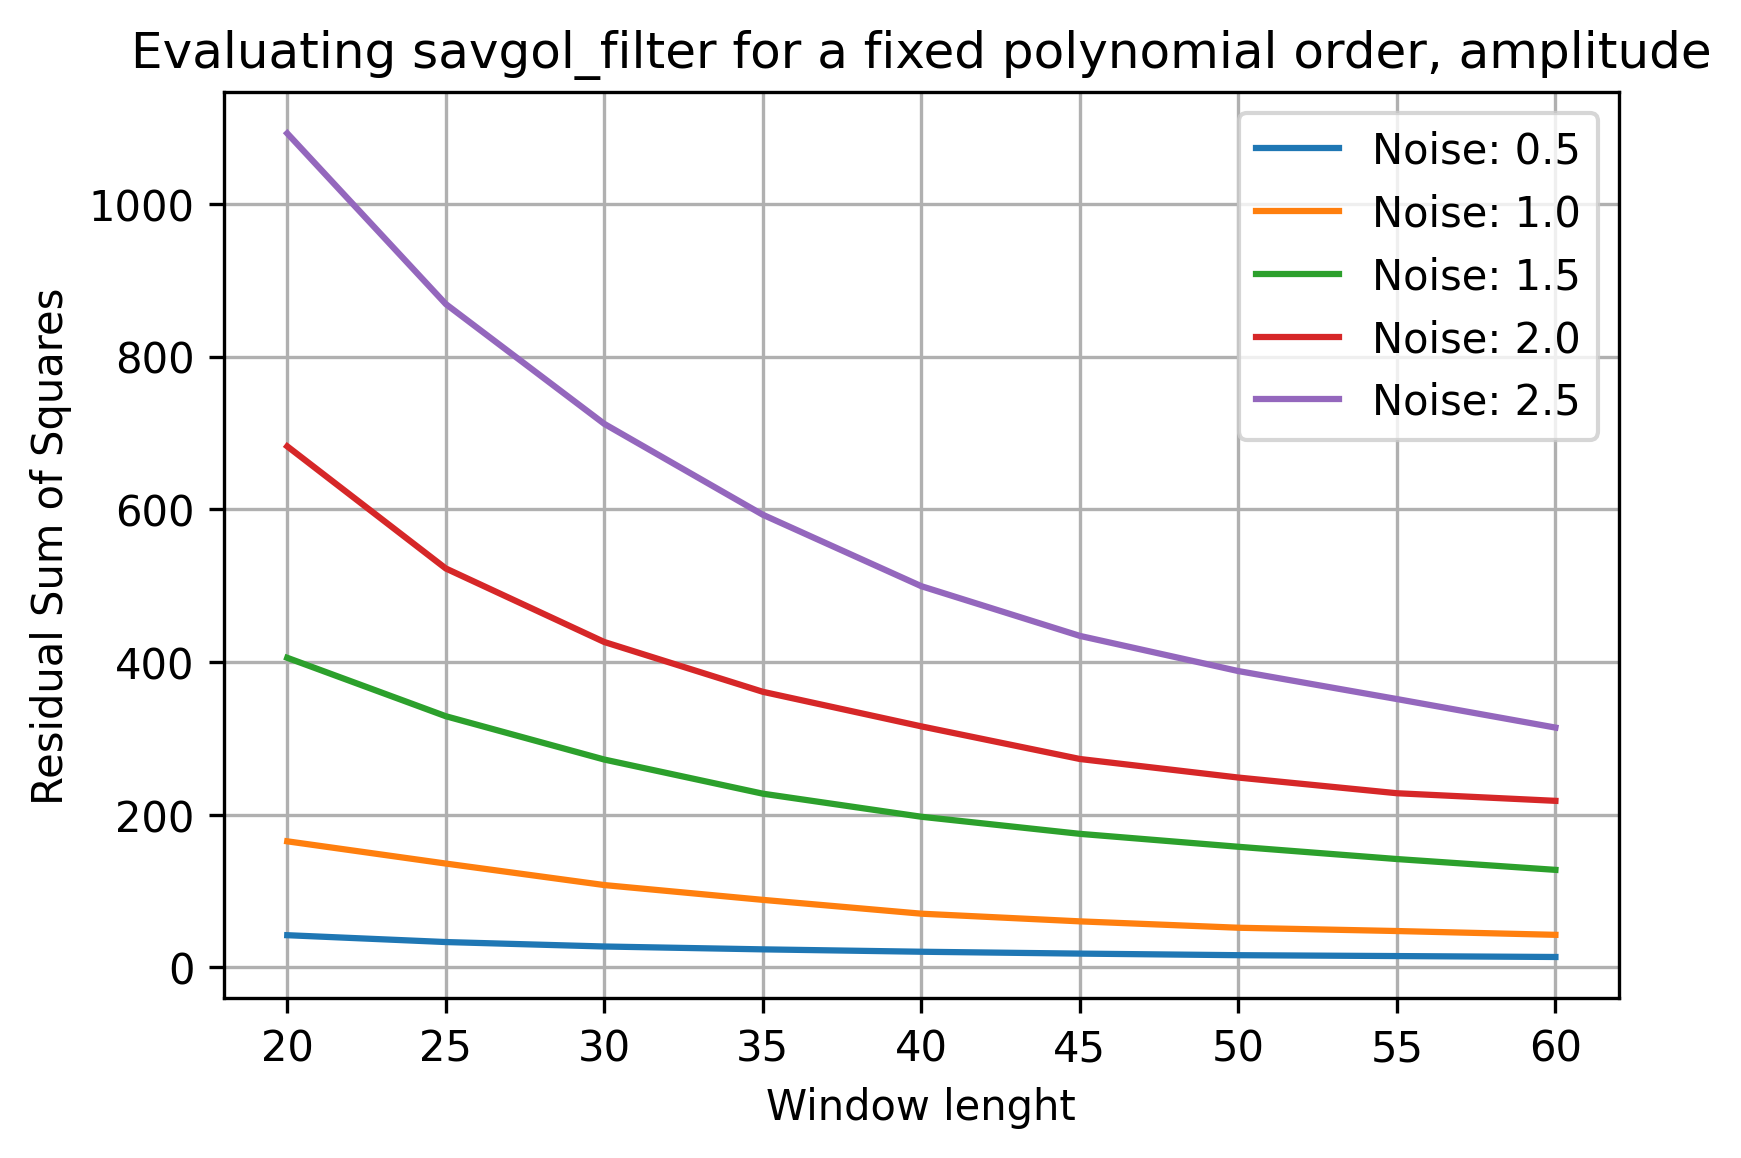

In [133]:
plt.figure(dpi = 300)
for k in range(len(total_rss)):
    plt.plot(wl, total_rss[k], label='Noise: ' + str(noises[k]))

plt.title('Evaluating savgol_filter for a fixed polynomial order, amplitude')
plt.xlabel('Window lenght')
plt.ylabel('Residual Sum of Squares')
plt.legend()
plt.grid()
plt.show()

Text(0.5, 0, 'rss')

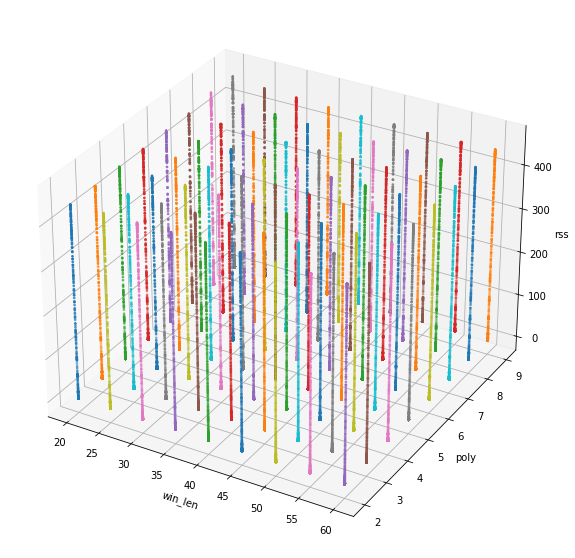

In [160]:
signal = gen_signal(baseline=-10, amplitude=100, noise_lev=1, plot=False, pulse_start=np.random.uniform(199.5,200.5))
win_len = np.linspace(20, 60, 9)

fig = plt.figure(figsize = (10,10)) 
ax = plt.axes(projection='3d')

for wl in win_len:
    for p in range(2, 10, 1):
        rss = savgol_rss(signal, clean, window_length=wl, poly=p, n=0, plot=False)
        ax.scatter3D(wl, p, rss, s=3)

ax.set_xlabel('win_len')   
ax.set_ylabel('poly')   
ax.set_zlabel('rss')